In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

import itertools
import pickle

import pandas as pd
from scipy.io import savemat, loadmat
import seaborn as sns
from sklearn.metrics import (log_loss, mean_squared_error, roc_curve, auc,
                             precision_recall_fscore_support, confusion_matrix)
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from tqdm import tqdm, trange, tqdm_notebook as tqdmn

from BEKML import BEMKL, plot_distplot
from utils import poly_kernel, gauss_kernel, scoring, plot_kernel_importances, plot_e_a_mu, plot_compare_metrics

sns.set(style='ticks', context='talk')
np.set_printoptions(precision=4, linewidth=100)

Populating the interactive namespace from numpy and matplotlib


/home/mtambos/anaconda/envs/pml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
data = pd.read_csv('data/breast.csv', names=list(range(11)), index_col=0, na_values='?')
display(data.describe())
data = data.dropna()
display(data.head())
data.describe()

,1,2,3,4,5,6,7,8,9,10
count,699.000000,699.000000,699.000000,699.000000,699.000000,683.000000,699.000000,699.000000,699.000000,699.000000
mean,4.417740,3.134478,3.207439,2.806867,3.216023,3.544656,3.437768,2.866953,1.589413,2.689557
std,2.815741,3.051459,2.971913,2.855379,2.214300,3.643857,2.438364,3.053634,1.715078,0.951273
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000,4.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


,1,2,3,4,5,6,7,8,9,10
0,,,,,,,,,,
1000025,5,1,1,1,2,1.0,3,1,1,2
1002945,5,4,4,5,7,10.0,3,2,1,2
1015425,3,1,1,1,2,2.0,3,1,1,2
1016277,6,8,8,1,3,4.0,3,7,1,2
1017023,4,1,1,3,2,1.0,3,1,1,2


,1,2,3,4,5,6,7,8,9,10
count,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,4.442167,3.150805,3.215227,2.830161,3.234261,3.544656,3.445095,2.869693,1.603221,2.699854
std,2.820761,3.065145,2.988581,2.864562,2.223085,3.643857,2.449697,3.052666,1.732674,0.954592
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000,4.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [3]:
X = data.iloc[:, :-1].values.copy()
y = data.iloc[:, -1].values.copy()
N, D = X.shape
y[y == 2] = -1
y[y == 4] = 1
display(X.shape, y.shape, y.mean())

(683, 9)

(683,)

-0.3001464128843338

In [4]:
rbf_init, rbf_end = -3, 7
ply_init, ply_end = 1, 4

kernel_attrs = [('rbf', 'all', i) for i in range(rbf_init, rbf_end)]
kernels = [lambda A, B: gauss_kernel(A, B, 2**i)
           for i in range(rbf_init, rbf_end)]

kernel_attrs += [('poly', 'all', i) for i in range(ply_init, ply_end)]
kernels += [lambda A, B: poly_kernel(A, B, 1, i)
            for i in range(ply_init, ply_end)]

kernel_attrs += [('rbf', j, i) for i in range(rbf_init, rbf_end)
                 for j in range(D)]
kernels += [lambda A, B: gauss_kernel(A[:, j:j+1], B[:, j:j+1], 2**i)
            for i in range(rbf_init, rbf_end) for j in range(D)]

kernel_attrs += [('poly', j, i) for i in range(ply_init, ply_end)
                 for j in range(D)]
kernels += [lambda A, B: poly_kernel(A[:, j:j+1], B[:, j:j+1], 1, i)
            for i in range(ply_init, ply_end) for j in range(D)]
len(kernels), len(kernel_attrs)

(130, 130)

In [5]:
X_train, X_test, y_train, y_test =\
        train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

In [6]:
normalizer = Normalizer()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

# Paper hyperparameters

In [14]:
max_iter = 10000
model1 = BEMKL(kernels=kernels, hyp_lambda_alpha=1, hyp_lambda_beta=1,
               hyp_gamma_alpha=1, hyp_gamma_beta=1,
               hyp_omega_alpha=1, hyp_omega_beta=1,
               e_null_thrsh=1e-3, filter_kernels=True, filter_sv=True, verbose=10,
               max_iter=max_iter, hyperopt_enabled=False)
model1.fit(X_train_norm, y_train)

Iter: 10. Bound: -1384.5723
Iter: 20. Bound: -1312.7521
Iter: 30. Bound: -1300.4564
Iter: 40. Bound: -1279.9215
Iter: 50. Bound: -1271.4881
Iter: 60. Bound: -1260.6789
Iter: 70. Bound: -1246.9244
Iter: 80. Bound: -1241.2290
Iter: 90. Bound: -1233.6319
Iter: 100. Bound: -1225.5807
Iter: 110. Bound: -1221.1682
Iter: 120. Bound: -1215.4687
Iter: 130. Bound: -1206.4671
Iter: 140. Bound: -1202.0409
Iter: 150. Bound: -1199.8827
Iter: 160. Bound: -1198.4141
Iter: 170. Bound: -1197.1572
Iter: 180. Bound: -1195.9612
Iter: 190. Bound: -1194.7655
Iter: 200. Bound: -1193.5422
Iter: 210. Bound: -1192.2726
Iter: 220. Bound: -1190.9397
Iter: 230. Bound: -1189.5259
Iter: 240. Bound: -1188.0075
Iter: 250. Bound: -1186.3488
Iter: 260. Bound: -1184.4899
Iter: 270. Bound: -1182.2970
Iter: 280. Bound: -1179.1873
Iter: 290. Bound: -1174.3803
Iter: 300. Bound: -1171.0058
Iter: 310. Bound: -1167.3956
Iter: 320. Bound: -1163.0132
Iter: 330. Bound: -1156.5852
Iter: 340. Bound: -1136.4143
Iter: 350. Bound: -1113

Iter: 2850. Bound: -932.7232
Iter: 2860. Bound: -932.6864
Iter: 2870. Bound: -932.6493
Iter: 2880. Bound: -932.6119
Iter: 2890. Bound: -932.5743
Iter: 2900. Bound: -932.5365
Iter: 2910. Bound: -932.4984
Iter: 2920. Bound: -932.4601
Iter: 2930. Bound: -932.4216
Iter: 2940. Bound: -932.3829
Iter: 2950. Bound: -932.3441
Iter: 2960. Bound: -932.3050
Iter: 2970. Bound: -932.2657
Iter: 2980. Bound: -932.2263
Iter: 2990. Bound: -932.1867
Iter: 3000. Bound: -932.1469
Iter: 3010. Bound: -932.1070
Iter: 3020. Bound: -932.0669
Iter: 3030. Bound: -932.0266
Iter: 3040. Bound: -931.9862
Iter: 3050. Bound: -931.9457
Iter: 3060. Bound: -931.9049
Iter: 3070. Bound: -931.8641
Iter: 3080. Bound: -931.8231
Iter: 3090. Bound: -931.7819
Iter: 3100. Bound: -931.7406
Iter: 3110. Bound: -931.6991
Iter: 3120. Bound: -931.6575
Iter: 3130. Bound: -931.6157
Iter: 3140. Bound: -931.5739
Iter: 3150. Bound: -931.5318
Iter: 3160. Bound: -931.4896
Iter: 3170. Bound: -931.4473
Iter: 3180. Bound: -931.4048
Iter: 3190. Bo

Iter: 5680. Bound: -913.7601
Iter: 5690. Bound: -913.6407
Iter: 5700. Bound: -913.5206
Iter: 5710. Bound: -913.3998
Iter: 5720. Bound: -913.2784
Iter: 5730. Bound: -913.1562
Iter: 5740. Bound: -913.0334
Iter: 5750. Bound: -912.9099
Iter: 5760. Bound: -912.7856
Iter: 5770. Bound: -912.6606
Iter: 5780. Bound: -912.5349
Iter: 5790. Bound: -912.4085
Iter: 5800. Bound: -912.2813
Iter: 5810. Bound: -912.1534
Iter: 5820. Bound: -912.0247
Iter: 5830. Bound: -911.8953
Iter: 5840. Bound: -911.7651
Iter: 5850. Bound: -911.6342
Iter: 5860. Bound: -911.5024
Iter: 5870. Bound: -911.3699
Iter: 5880. Bound: -911.2366
Iter: 5890. Bound: -911.1025
Iter: 5900. Bound: -910.9676
Iter: 5910. Bound: -910.8319
Iter: 5920. Bound: -910.6954
Iter: 5930. Bound: -910.5580
Iter: 5940. Bound: -910.4198
Iter: 5950. Bound: -910.2808
Iter: 5960. Bound: -910.1409
Iter: 5970. Bound: -910.0002
Iter: 5980. Bound: -909.8586
Iter: 5990. Bound: -909.7162
Iter: 6000. Bound: -909.5728
Iter: 6010. Bound: -909.4286
Iter: 6020. Bo

Iter: 8510. Bound: -830.0759
Iter: 8520. Bound: -830.0149
Iter: 8530. Bound: -829.9558
Iter: 8540. Bound: -829.8985
Iter: 8550. Bound: -829.8431
Iter: 8560. Bound: -829.7893
Iter: 8570. Bound: -829.7373
Iter: 8580. Bound: -829.6868
Iter: 8590. Bound: -829.6379
Iter: 8600. Bound: -829.5905
Iter: 8610. Bound: -829.5446
Iter: 8620. Bound: -829.5001
Iter: 8630. Bound: -829.4570
Iter: 8640. Bound: -829.4151
Iter: 8650. Bound: -829.3746
Iter: 8660. Bound: -829.3352
Iter: 8670. Bound: -829.2970
Iter: 8680. Bound: -829.2600
Iter: 8690. Bound: -829.2241
Iter: 8700. Bound: -829.1892
Iter: 8710. Bound: -829.1554
Iter: 8720. Bound: -829.1226
Iter: 8730. Bound: -829.0907
Iter: 8740. Bound: -829.0597
Iter: 8750. Bound: -829.0297
Iter: 8760. Bound: -829.0004
Iter: 8770. Bound: -828.9721
Iter: 8780. Bound: -828.9445
Iter: 8790. Bound: -828.9177
Iter: 8800. Bound: -828.8916
Iter: 8810. Bound: -828.8663
Iter: 8820. Bound: -828.8416
Iter: 8830. Bound: -828.8176
Iter: 8840. Bound: -828.7943
Iter: 8850. Bo

BEMKL(a_null_thrsh=1e-06, e_null_thrsh=0.001, filter_kernels=True,
   filter_sv=True, hyp_gamma_alpha=1, hyp_gamma_beta=1, hyp_lambda_alpha=1,
   hyp_lambda_beta=1, hyp_omega_alpha=1, hyp_omega_beta=1,
   hyperopt_enabled=False, hyperopt_every=5, hyperopt_max_iter=100,
   hyperopt_tol=1, init_vars=None, k_norm_type='kernel',
   kernels=[<function <listcomp>.<lambda> at 0x7f76709120d0>, <function <listcomp>.<lambda> at 0x7f76709121e0>, <function <listcomp>.<lambda> at 0x7f7670912378>, <function <listcomp>.<lambda> at 0x7f7670912268>, <function <listcomp>.<lambda> at 0x7f7670912488>, <function <listcomp>.<lambda> at 0x7f7670... <function <listcomp>.<lambda> at 0x7f76708ad7b8>, <function <listcomp>.<lambda> at 0x7f76708ad840>],
   margin=1, max_iter=10000, random_state=None, sigma_g=0.1, verbose=10)

In [15]:
max_iter = 10000
ho_model1 = BEMKL(kernels=kernels, hyp_lambda_alpha=1, hyp_lambda_beta=1,
                  hyp_gamma_alpha=1, hyp_gamma_beta=1,
                  hyp_omega_alpha=1, hyp_omega_beta=1,
                  e_null_thrsh=1e-3, filter_kernels=True, filter_sv=True, verbose=100,
                  max_iter=max_iter, hyperopt_enabled=True,
                  hyperopt_max_iter=99, hyperopt_every=1000, hyperopt_tol=5)
ho_model1.fit(X_train_norm, y_train)

Iter: 100. Bound: -1227.4927
Iter: 200. Bound: -1151.6297
Iter: 300. Bound: -1121.4931
Iter: 400. Bound: -1092.2267
Iter: 500. Bound: -1080.8439
Iter: 600. Bound: -1070.8881
Iter: 700. Bound: -1044.3383
Iter: 800. Bound: -1033.3370
Iter: 900. Bound: -1025.5122
Iter: 1000. Bound: -1001.6437
Iter: 1100. Bound: -964.9563
Iter: 1200. Bound: -941.6829
Iter: 1300. Bound: -931.4062
Iter: 1400. Bound: -927.2936
Iter: 1500. Bound: -924.5474
Iter: 1600. Bound: -918.6983
Iter: 1700. Bound: -917.5549
Iter: 1800. Bound: -917.7844
Iter: 1900. Bound: -917.9483
Iter: 2000. Bound: -918.2102
Iter: 2100. Bound: -902.1253
Iter: 2200. Bound: -901.9123
Iter: 2300. Bound: -901.6240
Iter: 2400. Bound: -901.3093
Iter: 2500. Bound: -900.9815
Iter: 2600. Bound: -900.6438
Iter: 2700. Bound: -900.2969
Iter: 2800. Bound: -899.9408
Iter: 2900. Bound: -899.5753
Iter: 3000. Bound: -899.2001
Iter: 3100. Bound: -884.7074
Iter: 3200. Bound: -884.3493
Iter: 3300. Bound: -883.9626
Iter: 3400. Bound: -883.5605
Iter: 3500. B

BEMKL(a_null_thrsh=1e-06, e_null_thrsh=0.001, filter_kernels=True,
   filter_sv=True, hyp_gamma_alpha=1.6403978882163956,
   hyp_gamma_beta=1.2348171932761411, hyp_lambda_alpha=1.8375376191487345,
   hyp_lambda_beta=0.5944613976125775, hyp_omega_alpha=1.7981011313993889,
   hyp_omega_beta=1.7556245237509165, hyperopt_enabled=True,
   hyperopt_every=1000, hyperopt_max_iter=99, hyperopt_tol=5,
   init_vars=None, k_norm_type='kernel',
   kernels=[<function <listcomp>.<lambda> at 0x7f76709120d0>, <function <listcomp>.<lambda> at 0x7f76709121e0>, <function <listcomp>.<lambda> at 0x7f7670912378>, <function <listcomp>.<lambda> at 0x7f7670912268>, <function <listcomp>.<lambda> at 0x7f7670912488>, <function <listcomp>.<lambda> at 0x7f7670... <function <listcomp>.<lambda> at 0x7f76708ad7b8>, <function <listcomp>.<lambda> at 0x7f76708ad840>],
   margin=1, max_iter=10000, random_state=None,
   sigma_g=0.09959975456095746, verbose=100)

In [16]:
[(k, v) for k, v in ho_model1.get_params().items() if k.startswith('hyp_')]

[('hyp_lambda_alpha', 1.8375376191487345),
 ('hyp_lambda_beta', 0.5944613976125775),
 ('hyp_gamma_alpha', 1.6403978882163956),
 ('hyp_gamma_beta', 1.2348171932761411),
 ('hyp_omega_alpha', 1.7981011313993889),
 ('hyp_omega_beta', 1.7556245237509165)]

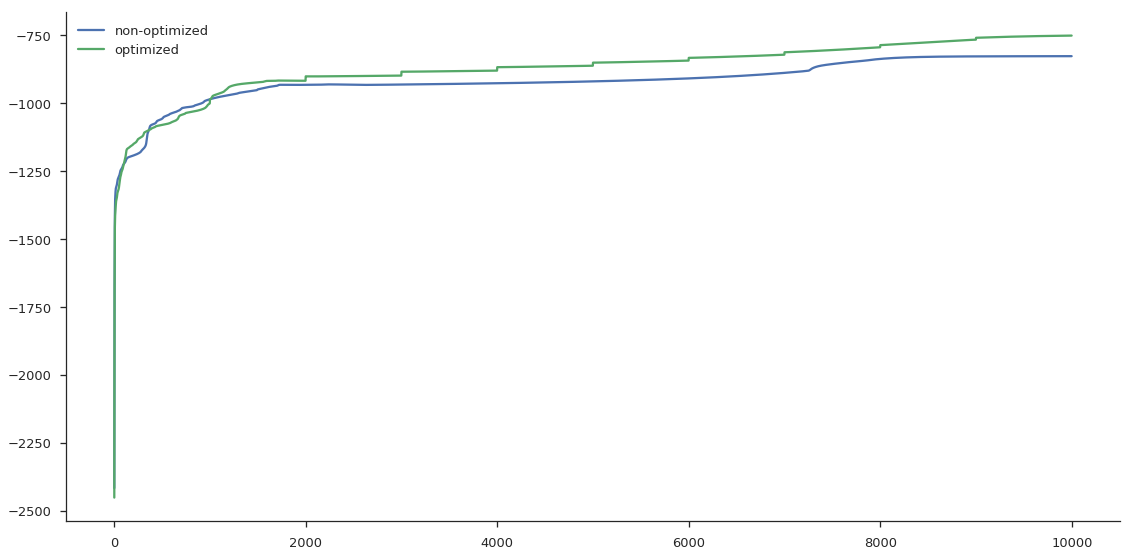

In [17]:
fig = plt.figure(figsize=(16, 8))
ax = fig.gca()
from_iter = 2
ax.plot([b[0] for b in model1.bounds[from_iter:]], label='non-optimized')
ax.plot([b[0] for b in ho_model1.bounds[from_iter:]], label='optimized')
ax.legend()
sns.despine()
plt.tight_layout()

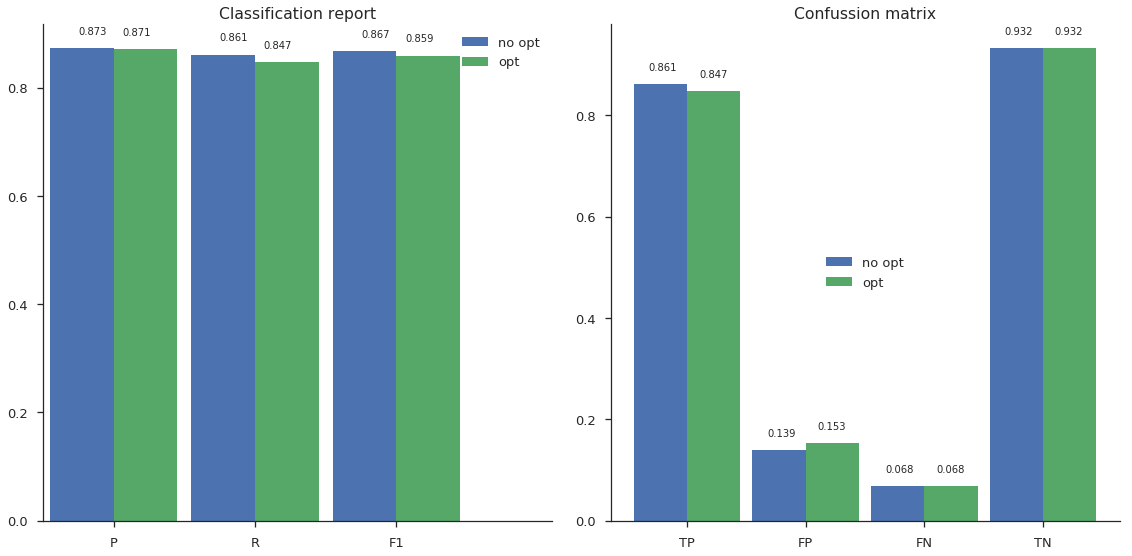

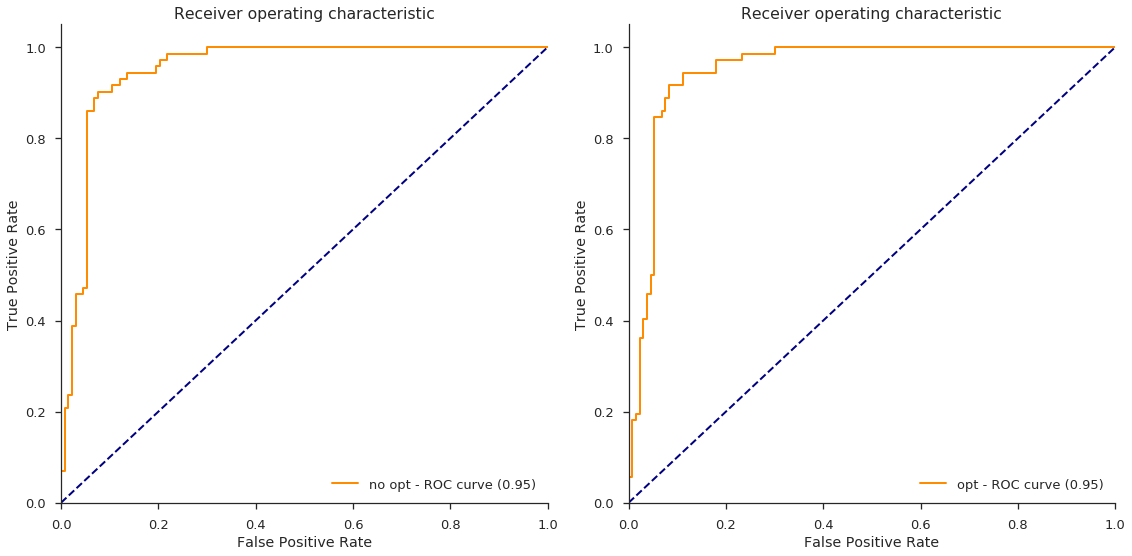

In [34]:
from utils import plot_compare_metrics

def _binarize(y_pred_proba: np.ndarray):
    y_pred = np.argwhere(y_pred_proba >= 0.5)[:, 1]
    y_pred[y_pred == 0] = -1
    return y_pred.astype(int)

y_pred_proba = model1.predict_proba(X_test_norm)
y_pred_proba_ho = ho_model1.predict_proba(X_test_norm)

plot_compare_metrics(y_test,
                     _binarize(y_pred_proba), _binarize(y_pred_proba_ho),
                     y_pred_proba[:, 1], y_pred_proba_ho[:, 1],
                     'no opt', 'opt')

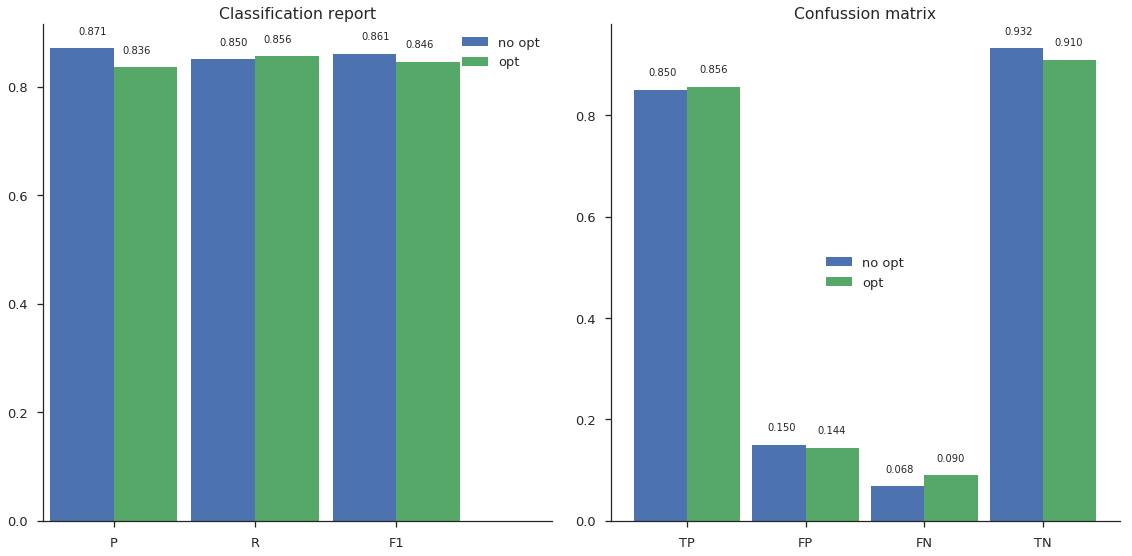

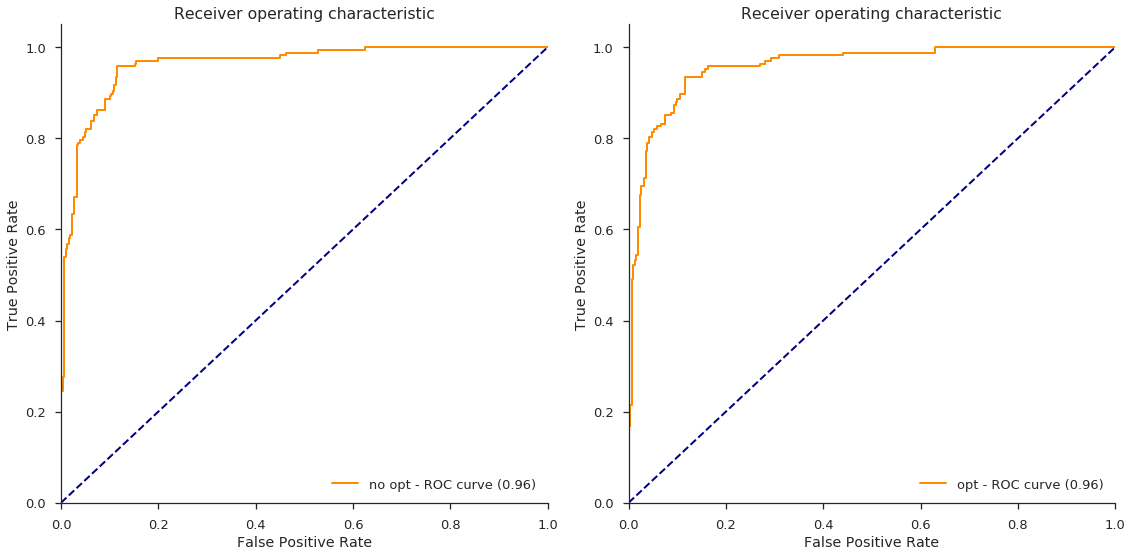

In [35]:
from utils import plot_compare_metrics

def _binarize(y_pred_proba: np.ndarray):
    y_pred = np.argwhere(y_pred_proba >= 0.5)[:, 1]
    y_pred[y_pred == 0] = -1
    return y_pred.astype(int)

y_pred_proba = model1.predict_proba(X_train_norm)
y_pred_proba_ho = ho_model1.predict_proba(X_train_norm)

plot_compare_metrics(y_train,
                     _binarize(y_pred_proba), _binarize(y_pred_proba_ho),
                     y_pred_proba[:, 1], y_pred_proba_ho[:, 1],
                     'no opt', 'opt')

In [9]:
with open('model1.pickle', 'wb') as fp:
    model1.set_params(kernels=None)
    model1.kernels_orig = None
    ho_model1.set_params(kernels=None)
    ho_model1.kernels_orig = None
    pickle.dump({'model1': model1, 'ho_model1': ho_model1, 'normalizer': normalizer}, fp)

In [10]:
with open('model1.pickle', 'rb') as fp:
    models_dict = pickle.load(fp)

model1 = models_dict['model1']
ho_model1 = models_dict['ho_model1']
normalizer = models_dict['normalizer']

In [11]:
model1.set_params(kernels=kernels)
model1.kernels_orig = kernels
ho_model1.set_params(kernels=kernels)
ho_model1.kernels_orig = kernels